# Import data and variables

In [1]:
# import python module

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

from tqdm import tqdm
from scipy.fftpack import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from sklearn.metrics import r2_score

In [2]:
# import data file

input_file = 'R04.bottom.csv'
x_or_y = 'x'                              # data direction for 1D extraction (type 'x' or 'y')
row_no = 250                              # row no. for 1D data extraction

In [3]:
# assign constant

## smoothing Gaussian filter
lambda_s = 1                             # micro-m
freq_s = 1/lambda_s                      # (micro-m)^-1

## cut-off Gaussian filter
lambda_c = 50                            # micro-m
freq_c = 1/lambda_c                      # (micro-m)^-1

## dominant freq
ratio_amp_dom2max_1D = 10                 # %
accept_dom_rSqua_2D = 0.5                 # value from 0 to 1
                                            ## 0 = estimated data 'poorly' fit the reference data
                                            ## 1 = estimated data 'well' fit the reference data

#------------------------------------------------------------------------------------------------------#            
            
## constant for gaussian filter (do not touch)
alfa = 0.4697
beta = 0.2206

In [4]:
# to trim off unusable area
# ex. processed surface (drill, mill), the interested height is only one part of the measured surface
# for surface preview, see section 2.1

trim_command = 'y'                        # 'y' if trim, 'n' if not-trim
trim_min = 200                            # um
trim_max = 1200                           # um

In [5]:
# point axis for surface reconstruction

data_pnts_recon = 26                     # point number of the reconstructed surface (include start and end points)
elemsize_recon = 50                      # element size
                                              ## point interval: elemsize_recon/(data_pnts_recon-1) has to be interger  

data_list_recon = np.linspace(0, elemsize_recon, data_pnts_recon)     # numpy.linspace(start, stop, num)
data_len_recon = data_list_recon[-1]
data_interval_recon = data_list_recon[1] - data_list_recon[0]
axis_dist_recon = (0, data_len_recon, 0, data_len_recon)

print(data_list_recon)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50.]


# Data pre-processing

## Data trimming

In [6]:
# import data
df = pd.read_csv(input_file, usecols=['# X','Y','Z'], skiprows=6)
df = df.rename(index=str, columns={"# X": "X"})

df.head()

,X,Y,Z
0,0.0000,0.0,0.481193
1,1.5625,0.0,0.511003
2,3.1250,0.0,0.668725
3,4.6875,0.0,0.641192
4,6.2500,0.0,0.423633


In [7]:
# trim input data to be square

x_list = sorted(list(set(df['X'])))
y_list = sorted(list(set(df['Y'])))

x_pnts = len(x_list)
y_pnts = len(y_list)
data_pnts = min(x_pnts, y_pnts)


# no of data point after cut = even

if data_pnts % 2 != 0:
    data_pnts = data_pnts - 1
    
data_list = x_list[0:data_pnts]
data_len = data_list[-1]
    
    
print(x_pnts)
print(y_pnts)
print(data_pnts)

930
933
930


In [8]:
# pivot table

df_raw = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
df_raw = df_raw.iloc[0:data_pnts, 0:data_pnts]

df_raw.iloc[0:5,0:5]

X,0.0,1.5625,3.125,4.6875,6.25
Y,,,,,
0.0000,0.481193,0.511003,0.668725,0.641192,0.423633
1.5625,0.380273,0.457129,0.533984,0.472088,0.362062
3.1250,-0.558252,-0.761285,-0.709036,-0.548387,-0.389690
4.6875,-0.042486,-0.040535,-0.046605,0.009546,-0.119883
6.2500,1.102110,0.786989,0.658535,0.684009,0.650839


In [9]:
# find index of trim_min, trim_max

if trim_command == 'y':

    trim_min_loc = 0
    trim_max_loc = 0

    for i in range(len(data_list)):
        if data_list[i] > trim_min:
            trim_min_loc = i
            break

    for i in range(len(data_list)):
        if data_list[len(data_list)-1-i] < trim_max:
            trim_max_loc = len(data_list)-1-i
            break
    
    if (trim_max_loc - trim_min_loc) % 2 != 0:               # no of data point after cut = even
        trim_min_loc = trim_min_loc + 1

In [10]:
# pivot table

if trim_command == 'y':
    df_2D = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
    df_2D = df_2D.iloc[trim_min_loc:trim_max_loc, trim_min_loc:trim_max_loc]

    df_2D.iloc[0:5,0:5]

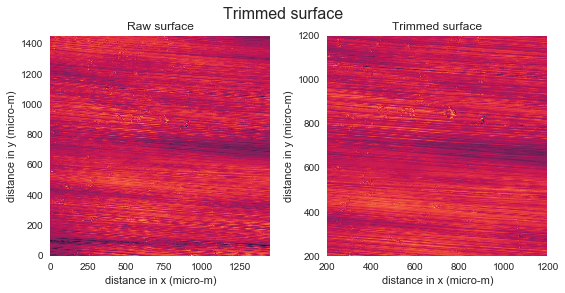

In [11]:
# plot trimmed surface

if trim_command == 'y':

    # set axis
    axis_dist_raw = (0, data_len, 0, data_len)                                          
    axis_dist_2D = (data_list[trim_min_loc], data_list[trim_max_loc], data_list[trim_min_loc], data_list[trim_max_loc])                                         
    v_min_raw = np.amin(df_raw.values)
    v_max_raw = np.amax(df_raw.values)


    plot_size = (8, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle("Trimmed surface", fontsize=16)

    ax1.imshow(df_raw, extent=axis_dist_raw, vmin=v_min_raw, vmax=v_max_raw)
    ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax1.title.set_text('Raw surface')
    ax1.grid(False)

    ax2.imshow(df_2D, extent=axis_dist_2D, vmin=v_min_raw, vmax=v_max_raw) 
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Trimmed surface')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)

In [12]:
# assign spatial axis

if trim_command == 'y':
    
    data_list = x_list[0:trim_max_loc-trim_min_loc]
    data_len = data_list[-1]
    data_pnts = len(data_list)

    print(trim_min_loc)
    print(trim_max_loc)
    print(data_pnts)

129
767
638


In [13]:
if trim_command == 'n':
    df_2D = df_raw.copy()

## Axis assigns

In [14]:
# show spatial axis

print(data_list[0:5], "...", data_list[-5:])
print(data_len)
print(data_pnts)

[0.0, 1.5625, 3.125, 4.6875, 6.25] ... [989.062, 990.625, 992.187, 993.75, 995.312]
995.312
638


In [15]:
# sampling info

samp_space = data_list[1] - data_list[0]             # micro-m
samp_rate = 1/samp_space                             # (micro-m)^(-1)

print(samp_space)
print(samp_rate)

1.5625
0.64


In [16]:
# assign freq axis

freq_full = fftfreq(data_pnts, samp_space)
freq_full_shift = fftshift(freq_full)
freq_half = freq_full_shift[freq_full_shift >= 0]

print(freq_full[0:5], "...", freq_full[-5:])
print(freq_full_shift[0:5], "...", freq_full_shift[-5:])
print(freq_half[0:5], "...", freq_half[-5:])

[0.         0.00100313 0.00200627 0.0030094  0.00401254] ... [-0.00501567 -0.00401254 -0.0030094  -0.00200627 -0.00100313]
[-0.32       -0.31899687 -0.31799373 -0.3169906  -0.31598746] ... [0.31498433 0.31598746 0.3169906  0.31799373 0.31899687]
[0.         0.00100313 0.00200627 0.0030094  0.00401254] ... [0.31498433 0.31598746 0.3169906  0.31799373 0.31899687]


## Extract row of data (1D)

In [17]:
# check selection in x or y direction
# extract out row of data

if x_or_y == 'x':
    z_data = df_2D.iloc[:, row_no].values
        
if x_or_y == 'y':
    z_data = df_2D.iloc[row_no, :].values

# Gaussian filter

## 1D-Gaussian

In [18]:
# create gaussian 1D

df_gauss_1D = pd.DataFrame(data = freq_full_shift, columns = ['freq']) 
df_gauss_1D['f_to_fc'] = df_gauss_1D['freq'] / freq_c
df_gauss_1D['low_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fc'])**2)
df_gauss_1D['high_gauss'] = 1 - df_gauss_1D['low_gauss']

df_gauss_1D.head()

,freq,f_to_fc,low_gauss,high_gauss
0,-0.320000,-16.000000,8.758648e-78,1.0
1,-0.318997,-15.949843,2.659496e-77,1.0
2,-0.317994,-15.899687,8.047243e-77,1.0
3,-0.316991,-15.849530,2.426501e-76,1.0
4,-0.315987,-15.799373,7.291205e-76,1.0


In [19]:
low_gauss_1D = df_gauss_1D['low_gauss'].values
high_gauss_1D = df_gauss_1D['high_gauss'].values

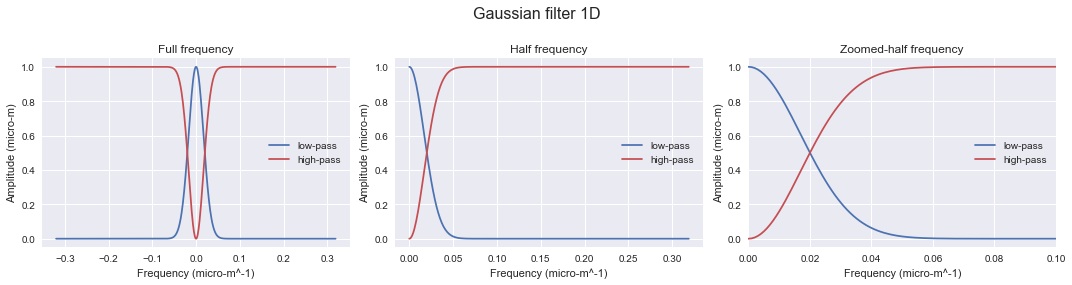

In [20]:
plot_size = (15, 4)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Gaussian filter 1D", fontsize=16)

ax1.plot(freq_full_shift, low_gauss_1D, 'b')
ax1.plot(freq_full_shift, high_gauss_1D, 'r')
ax1.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax1.title.set_text('Full frequency')
ax1.legend(('low-pass','high-pass'), loc='center right')

ax2.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax2.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax2.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax2.title.set_text('Half frequency')
ax2.legend(('low-pass','high-pass'), loc='center right')

ax3.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax3.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax3.set_xlim(0, freq_c*5)
ax3.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax3.title.set_text('Zoomed-half frequency')
ax3.legend(('low-pass','high-pass'), loc='center right')

plt.tight_layout()
f.subplots_adjust(top=0.8)

## 1D-Gaussian smoothing filter

In [21]:
# create gaussian smoothing filter 1D

df_gauss_1D['f_to_fs'] = df_gauss_1D['freq'] / freq_s
df_gauss_1D['smooth_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fs'])**2)

df_gauss_1D.head()

,freq,f_to_fc,low_gauss,high_gauss,f_to_fs,smooth_gauss
0,-0.320000,-16.000000,8.758648e-78,1.0,-0.320000,0.931487
1,-0.318997,-15.949843,2.659496e-77,1.0,-0.318997,0.931901
2,-0.317994,-15.899687,8.047243e-77,1.0,-0.317994,0.932314
3,-0.316991,-15.849530,2.426501e-76,1.0,-0.316991,0.932726
4,-0.315987,-15.799373,7.291205e-76,1.0,-0.315987,0.933136


In [22]:
smooth_gauss_1D = df_gauss_1D['smooth_gauss'].values

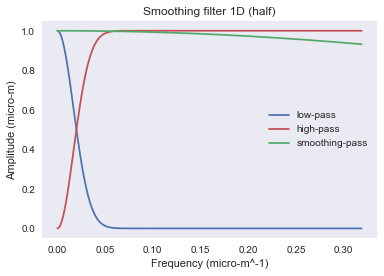

In [23]:
plt.title('Smoothing filter 1D (half)')

plt.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
plt.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
plt.plot(freq_half, smooth_gauss_1D[data_pnts//2:], 'g')

plt.ylabel('Amplitude (micro-m)')
plt.xlabel('Frequency (micro-m^-1)')
plt.legend(('low-pass','high-pass','smoothing-pass'), loc='center right')

plt.grid()
plt.show()

## 2D-Gaussian

In [24]:
# # prepare fx/fc and fy/fc to put in equation

# df_fx = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

# for i in range(data_pnts):
#     df_fx.iloc[i,:] = freq_full_shift                             # row by rows
    

# df_fy = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

# for i in range(data_pnts):
#     df_fy.iloc[:,i] = freq_full_shift                             # column by columns


# df_fx2fc = df_fx.copy() / freq_c
# df_fy2fc = df_fy.copy() / freq_c

In [25]:
# # input fx/fc and fy/fc to compute Gaussian

# df_low_gauss = np.exp(-np.pi * beta * (df_fx2fc.pow(2) + df_fy2fc.pow(2)))
# df_high_gauss = 1 - df_low_gauss

In [26]:
# from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=plt.figaspect(0.3))
# fig.suptitle('Gaussian filter 2D', fontsize=16)


# # First subplot
# ax = fig.add_subplot(1, 2, 1, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = df_low_gauss

# surf = ax.plot_surface(X, Y, Z)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Low Gaussian filter')


# # Second subplot
# ax = fig.add_subplot(1, 2, 2, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = df_high_gauss

# surf = ax.plot_surface(X, Y, Z)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude')
# ax.title.set_text('High Gaussian filter')


# plt.tight_layout()
# fig.subplots_adjust(top=0.88)
# plt.show()

## 2D-Gaussian smoothing filter

In [27]:
# # prepare fx/fc and fy/fc to put in equation

# df_fx2fs = df_fx.copy() / freq_s
# df_fy2fs = df_fy.copy() / freq_s

In [28]:
# # input fx/fc and fy/fc to compute Gaussian

# df_smooth_gauss = np.exp(-np.pi * beta * (df_fx2fs.pow(2) + df_fy2fs.pow(2)))

In [29]:
# fig = plt.figure(figsize=plt.figaspect(0.6))
# fig.suptitle('Smoothing filter 2D', fontsize=16)


# # First subplot
# ax = fig.add_subplot(1, 1, 1, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = df_smooth_gauss

# surf = ax.plot_surface(X, Y, Z)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')


# plt.tight_layout()
# fig.subplots_adjust(top=0.88)
# plt.show()

# Surface transformation

## 1D-data

### Fourier transform

In [30]:
z_fou_1D = fft(z_data) 
z_inv_1D = ifft(z_fou_1D)

In [31]:
# shift freq domain to multiply with Gaussian

z_fou_1D_shift = fftshift(z_fou_1D)


# amplitude of z-fourier

z_fou_1D_full = 1/data_pnts * abs(z_fou_1D_shift)
z_fou_1D_half = 2/data_pnts * abs(z_fou_1D[0:data_pnts//2])    # fourier amplitude correction
                                                               # [0:data_pnts//2] : to cut only positive half of freq
                                                               # abs() : to get magnitude
                                                               # /data_pnts : to normalized operation of FFT summation
                                                               # *2 : to supplement value of f negative to f positive

In [32]:
# set limit for graph plot (1D)

plt_dist_xlim_1D = data_len
plt_dist_zlim_1D = max(np.amax(z_data), abs(np.amin(z_data))) * 1.3
plt_freq_xlim_1D = samp_rate
plt_freq_zlim_1D = np.amax(z_fou_1D_half) * 1.3

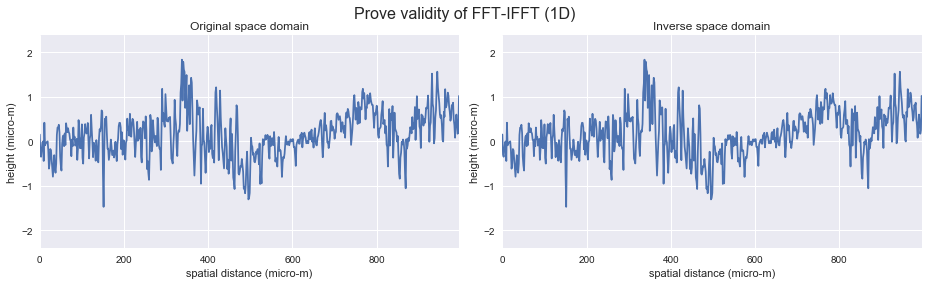

In [33]:
# prove validity of Fourier transform after cut outlier

plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Original space domain')

ax2.plot(data_list, z_inv_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Inverse space domain')

plt.tight_layout()
f.subplots_adjust(top=0.88)

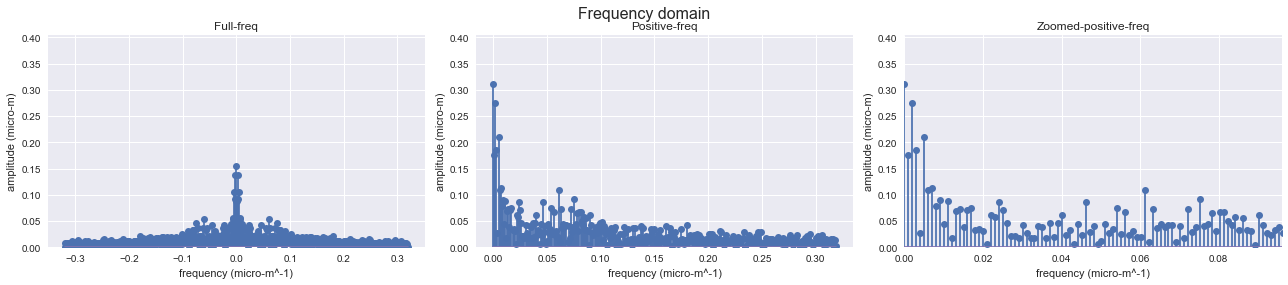

In [34]:
# plot freq domain

plot_size = (18, 4)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Frequency domain", fontsize=16)

ax1.stem(freq_full_shift, z_fou_1D_full)
ax1.set_ylim(0, plt_freq_zlim_1D)
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full-freq')

ax2.stem(freq_half, z_fou_1D_half)
ax2.set_ylim(0, plt_freq_zlim_1D)
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Positive-freq')

ax3.stem(freq_half, z_fou_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.15)
ax3.set_ylim(0, plt_freq_zlim_1D)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('Zoomed-positive-freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [35]:
# compare result

rSq_fft_1D = r2_score(z_data, z_inv_1D.real)

print('Prove validity of Fourier transform 1D')
print('R-square: ', rSq_fft_1D)

Prove validity of Fourier transform 1D
R-square:  1.0


### Smoothing filter

In [36]:
# assign dataframe for operation

df_conv_1D = pd.DataFrame(data=freq_full_shift, columns=['freq'])
df_conv_1D['z_fou'] = z_fou_1D_shift
df_conv_1D['low_gauss'] = low_gauss_1D
df_conv_1D['high_gauss'] = high_gauss_1D
df_conv_1D['smooth_gauss'] = smooth_gauss_1D

In [37]:
df_conv_1D['smooth_conv'] = df_conv_1D['z_fou'] * df_conv_1D['smooth_gauss']

df_conv_1D.head()

,freq,z_fou,low_gauss,high_gauss,smooth_gauss,smooth_conv
0,-0.320000,(5.546821630999993+0j),8.758648e-78,1.0,0.931487,(5.166794342103962+0j)
1,-0.318997,(0.9432983477275378+0.20468276470223934j),2.659496e-77,1.0,0.931901,(0.8790609609106702+0.19074413546303984j)
2,-0.317994,(2.9479648451924163+3.33330308292447j),8.047243e-77,1.0,0.932314,(2.7484292323684714+3.107685510020249j)
3,-0.316991,(-0.7658891439879127+0.09828839028363578j),2.426501e-76,1.0,0.932726,(-0.7143645683041685+0.09167611794140958j)
4,-0.315987,(-4.765427823426538+0.5741381813028386j),7.291205e-76,1.0,0.933136,(-4.4467940498959955+0.5357492219029781j)


In [38]:
# shift freq domain back for IFFT operation

z_fou_1D_ishift = ifftshift(df_conv_1D['z_fou'].values)
z_fou_smooth_1D_ishift = ifftshift(df_conv_1D['smooth_conv'].values)

In [39]:
# correct freq amplitude for graph plot

z_fou_smooth_1D_full = 1/data_pnts * abs(z_fou_smooth_1D_ishift)
z_fou_smooth_1D_half = 2/data_pnts * abs(z_fou_smooth_1D_ishift[0:data_pnts//2])

In [40]:
# inverse Fourier transform

z_inv_1D = ifft(z_fou_1D_ishift)
z_inv_smooth_1D = ifft(z_fou_smooth_1D_ishift)

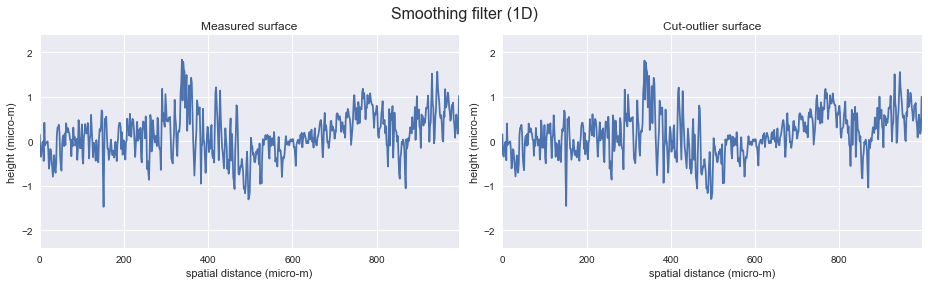

In [41]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Smoothing filter (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Measured surface')

ax2.plot(data_list, z_inv_smooth_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Cut-outlier surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [42]:
# compare result

rSq_ori_corr_1D = r2_score(z_data, z_inv_smooth_1D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_1D)

Original to cut-outlier surface
R-square:  0.9998569985044724


### Waviness-Roughness filter

In [43]:
# convolution by mulplication in freq domain

df_conv_1D['low_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['low_gauss']
df_conv_1D['high_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['high_gauss']

df_conv_1D.head()

,freq,z_fou,low_gauss,high_gauss,smooth_gauss,smooth_conv,low_conv,high_conv
0,-0.320000,(5.546821630999993+0j),8.758648e-78,1.0,0.931487,(5.166794342103962+0j),(4.525413181704398e-77+0j),(5.166794342103962+0j)
1,-0.318997,(0.9432983477275378+0.20468276470223934j),2.659496e-77,1.0,0.931901,(0.8790609609106702+0.19074413546303984j),(2.3378590930309644e-77+5.072832617576715e-78j),(0.8790609609106702+0.19074413546303984j)
2,-0.317994,(2.9479648451924163+3.33330308292447j),8.047243e-77,1.0,0.932314,(2.7484292323684714+3.107685510020249j),(2.2117278799880826e-76+2.5008301482893282e-76j),(2.7484292323684714+3.107685510020249j)
3,-0.316991,(-0.7658891439879127+0.09828839028363578j),2.426501e-76,1.0,0.932726,(-0.7143645683041685+0.09167611794140958j),(-1.733406229723145e-76+2.224521777916765e-77j),(-0.7143645683041685+0.09167611794140958j)
4,-0.315987,(-4.765427823426538+0.5741381813028386j),7.291205e-76,1.0,0.933136,(-4.4467940498959955+0.5357492219029781j),(-3.24224848158118e-75+3.9062571410606625e-76j),(-4.4467940498959955+0.5357492219029781j)


In [44]:
# shift freq domain back for IFFT operation

z_fou_low_1D_ishift = ifftshift(df_conv_1D['low_conv'].values)
z_fou_high_1D_ishift = ifftshift(df_conv_1D['high_conv'].values)

In [45]:
# correct freq amplitude for graph plot

z_fou_low_1D_full = 1/data_pnts * abs(z_fou_low_1D_ishift)
z_fou_low_1D_half = 2/data_pnts * abs(z_fou_low_1D_ishift[0:data_pnts//2])

z_fou_high_1D_full = 1/data_pnts * abs(z_fou_high_1D_ishift)
z_fou_high_1D_half = 2/data_pnts * abs(z_fou_high_1D_ishift[0:data_pnts//2])

In [46]:
# inverse Fourier transform

z_inv_low_1D = ifft(z_fou_low_1D_ishift)
z_inv_high_1D = ifft(z_fou_high_1D_ishift)

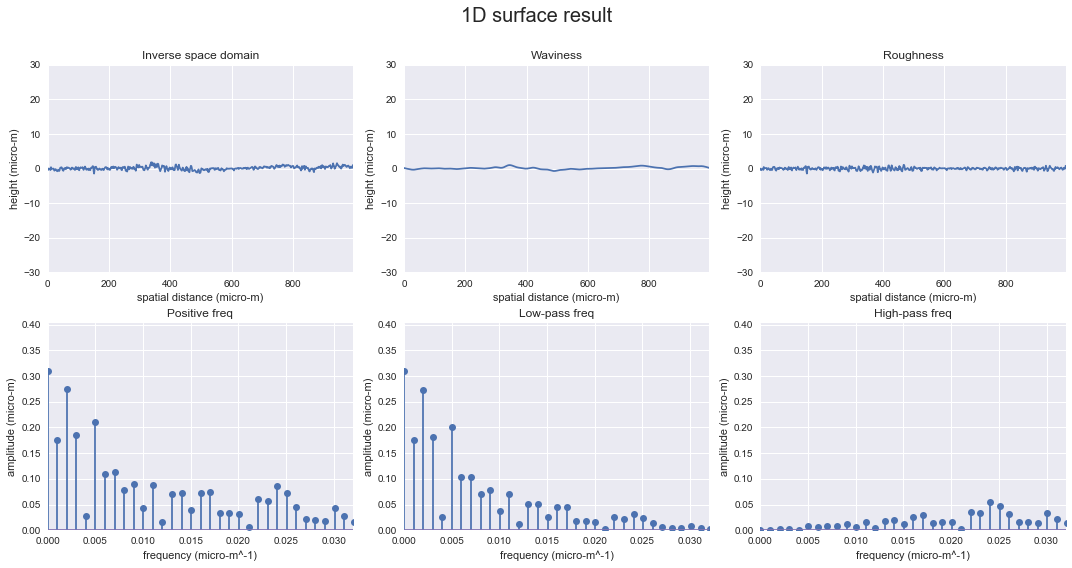

In [47]:
plot_size = (15, 8)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("1D surface result", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-30, 30)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-30, 30)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-30, 30)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness')

ax4.stem(freq_half, z_fou_smooth_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax4.set_ylim(0, plt_freq_zlim_1D)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Positive freq')

ax5.stem(freq_half, z_fou_low_1D_half)
ax5.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax5.set_ylim(0, plt_freq_zlim_1D)
ax5.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax5.title.set_text('Low-pass freq')

ax6.stem(freq_half, z_fou_high_1D_half)
ax6.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax6.set_ylim(0, plt_freq_zlim_1D)
ax6.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax6.title.set_text('High-pass freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

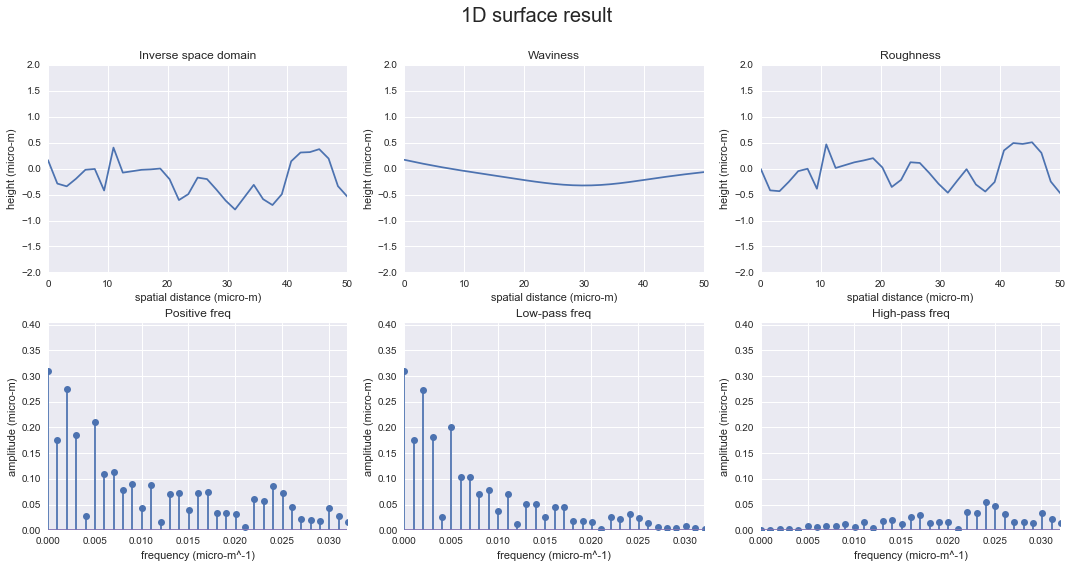

In [48]:
plot_size = (15, 8)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("1D surface result", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, 50)
ax1.set_ylim(-2, 2)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, 50)
ax2.set_ylim(-2, 2)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, 50)
ax3.set_ylim(-2, 2)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness')

ax4.stem(freq_half, z_fou_smooth_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax4.set_ylim(0, plt_freq_zlim_1D)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Positive freq')

ax5.stem(freq_half, z_fou_low_1D_half)
ax5.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax5.set_ylim(0, plt_freq_zlim_1D)
ax5.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax5.title.set_text('Low-pass freq')

ax6.stem(freq_half, z_fou_high_1D_half)
ax6.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax6.set_ylim(0, plt_freq_zlim_1D)
ax6.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax6.title.set_text('High-pass freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

## 2D-data

### Fourier transform

In [49]:
# z_fou_2D = fft2(df_2D)
# z_inv_2D = ifft2(z_fou_2D)

In [50]:
# # shift freq domain to plot graph

# z_fou_2D_shift = fftshift(z_fou_2D)

In [51]:
# # set limit for graph plot (2D)

# axis_dist = (0, data_len, 0, data_len)         
# axis_freq = (0, samp_rate, 0, samp_rate)         
# v_min_dist = np.amin(z_inv_2D.real)
# v_max_dist = np.amax(z_inv_2D.real)
# v_min_fAmp = np.amin(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
# v_max_fAmp = np.amax(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
# v_min_fPhs = np.amin(np.angle(z_fou_2D_shift))
# v_max_fPhs = np.amax(np.angle(z_fou_2D_shift))

# plt_dist_xlim_2D = data_len
# plt_dist_zlim_2D = max(np.amax(df_2D.values), abs(np.amin(df_2D.values))) * 1.3
# plt_freq_xlim_2D = samp_rate
# plt_freq_zlim_2D = np.amax(z_fou_2D)/data_pnts**2 * 1.3

In [52]:
# # prove validity of Fourier transform after cut outlier

# plot_size = (8, 4)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
# f.suptitle("Prove validity of FFT-IFFT (2D)", fontsize=16)

# ax1.imshow(df_2D, extent=axis_dist)
# ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax1.title.set_text('Original space domain')
# ax1.grid(False)

# ax2.imshow(z_inv_2D.real, extent=axis_dist) 
# ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax2.title.set_text('Inverse space domain')
# ax2.grid(False)

# plt.tight_layout()
# f.subplots_adjust(top=0.88)

In [53]:
# # plot freq domain
# # enhance freq domain by log-scale to show difference of freq hight


# fig = plt.figure(figsize=plt.figaspect(0.3))
# fig.suptitle('Fourier frequency domain', fontsize=16)


# # First subplot
# ax = fig.add_subplot(1, 2, 1, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_2D_shift)

# surf = ax.plot_surface(X, Y, Z)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Freq domain')


# # Second subplot
# ax = fig.add_subplot(1, 2, 2, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = np.log10(1/data_pnts**2 * abs(z_fou_2D_shift))                   # log10 to enhance value difference

# surf = ax.plot_surface(X, Y, Z)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='log10(y-freq)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Enhanced freq domain (log-scale)')


# plt.tight_layout()
# fig.subplots_adjust(top=0.88)
# plt.show()

In [54]:
# # compare result

# rSq_fft_2D = r2_score(df_2D, z_inv_2D.real)

# print('Prove validity of Fourier transform 2D')
# print('R-square: ', rSq_fft_2D)

### Smoothing filter

In [55]:
# # smoothing convolution

# z_fou_smooth_2D = np.multiply(z_fou_2D_shift, df_smooth_gauss)

In [56]:
# # shift freq domain back for IFFT operation

# z_fou_2D_ishift = ifftshift(z_fou_2D_shift)
# z_fou_smooth_2D_ishift = ifftshift(z_fou_smooth_2D)

In [57]:
# # inverse Fourier transform

# z_inv_2D = ifft2(z_fou_2D_ishift)
# z_inv_smooth_2D = ifft2(z_fou_smooth_2D_ishift)

In [58]:
# fig = plt.figure(figsize=plt.figaspect(0.3))
# fig.suptitle('Smoothing filter (2D)', fontsize=16)


# # First subplot
# ax = fig.add_subplot(1, 2, 1, projection='3d')           

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Measured surface')


# # Second subplot
# ax = fig.add_subplot(1, 2, 2, projection='3d')           

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_smooth_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Cut-outlier surface')


# plt.tight_layout()
# fig.subplots_adjust(top=0.88)
# plt.show()

In [59]:
# # compare result

# rSq_ori_corr_2D = r2_score(df_2D, z_inv_smooth_2D.real)

# print('Original to cut-outlier surface')
# print('R-square: ', rSq_ori_corr_2D)

### Waviness-Roughness filter

In [60]:
# # convolution by element-wise mulplication in freq domain

# ## low-pass convolution
# z_fou_low_2D = np.multiply(z_fou_smooth_2D, df_low_gauss)


# ## high-pass convolution
# z_fou_high_2D = np.multiply(z_fou_smooth_2D, df_high_gauss)

In [61]:
# # shift freq domain back for IFFT operation

# z_fou_low_2D_ishift = ifftshift(z_fou_low_2D)
# z_fou_high_2D_ishift = ifftshift(z_fou_high_2D)

In [62]:
# # inverse Fourier transform

# z_inv_low_2D = ifft2(z_fou_low_2D_ishift)
# z_inv_high_2D = ifft2(z_fou_high_2D_ishift)

In [63]:
# # image plot

# plot_size = (10, 9)
# f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=plot_size)
# f.suptitle("2D surface result", fontsize=16)

# ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax1.title.set_text('Inversed surface')
# ax1.grid(False)

# ax2.imshow(z_inv_low_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax2.title.set_text('Waviness')
# ax2.grid(False)

# ax3.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax3.title.set_text('Roughness')
# ax3.grid(False)

# ax4.imshow(np.log10(1/data_pnts**2 * abs(z_fou_smooth_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)    # log10 to enhance the result
# ax4.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
# ax4.title.set_text('Freq amplitude')
# ax4.grid(False)

# ax5.imshow(np.log10(1/data_pnts**2 * abs(z_fou_low_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
# ax5.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
# ax5.title.set_text('Freq amplitude: low-pass')
# ax5.grid(False)

# ax6.imshow(np.log10(1/data_pnts**2 * abs(z_fou_high_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
# ax6.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
# ax6.title.set_text('Freq amplitude: high-pass')
# ax6.grid(False)

# ax7.imshow(np.angle(z_fou_smooth_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
# ax7.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
# ax7.title.set_text('Freq phase')
# ax7.grid(False)

# ax8.imshow(np.angle(z_fou_low_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
# ax8.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
# ax8.title.set_text('Freq phase: high-pass')
# ax8.grid(False)

# ax9.imshow(np.angle(z_fou_high_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
# ax9.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
# ax9.title.set_text('Freq phase: low-pass')
# ax9.grid(False)

# plt.tight_layout()
# f.subplots_adjust(top=0.88)

In [64]:
# # surface plot

# from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

# plot_size = (15, 7)
# fig = plt.figure(figsize=plot_size)                                     # set up figure size
# fig.suptitle('2D surface result', fontsize=16)


# # First subplot
# ax = fig.add_subplot(2, 3, 1, projection='3d')           

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_smooth_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Inversed surface')


# # Second subplot
# ax = fig.add_subplot(2, 3, 2, projection='3d')            

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_low_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Waviness')


# # third subplot
# ax = fig.add_subplot(2, 3, 3, projection='3d')            

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_high_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Roughness')


# # fourth subplot
# ax = fig.add_subplot(2, 3, 4, projection='3d')          

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Freq amplitude')


# # fifth subplot
# ax = fig.add_subplot(2, 3, 5, projection='3d')            

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_low_2D)

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Freq amplitude: high-pass')


# # sixth subplot
# ax = fig.add_subplot(2, 3, 6, projection='3d')            

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_high_2D)

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Freq amplitude: low-pass')


# plt.tight_layout()
# fig.subplots_adjust(top=0.88)
# plt.show()

## 1D and 2D surface comparison

In [65]:
# # extract row of 2D surface transformation to compare with 1D surface transformation

# if x_or_y == 'x': 
#     z_inv_select = z_inv_smooth_2D[:, row_no]
#     z_inv_select_low = z_inv_low_2D[:, row_no]
#     z_inv_select_high = z_inv_high_2D[:, row_no]
        
# if x_or_y == 'y':
#     z_inv_select = z_inv_smooth_2D[row_no, :]
#     z_inv_select_low = z_inv_low_2D[row_no, :]
#     z_inv_select_high = z_inv_high_2D[row_no, :]

In [66]:
# # plot compare 1D and 2D result in 1D-display

# plot_size = (15, 7)
# f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
# f.suptitle("Compare 1D and 2D operation", fontsize=20)

# ax1.plot(data_list, z_inv_smooth_1D.real)
# ax1.set_xlim(0, plt_dist_xlim_1D)
# ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax1.title.set_text('Inverse space domain: 1D')

# ax2.plot(data_list, z_inv_low_1D.real)
# ax2.set_xlim(0, plt_dist_xlim_1D)
# ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax2.title.set_text('Waviness: 1D')

# ax3.plot(data_list, z_inv_high_1D.real)
# ax3.set_xlim(0, plt_dist_xlim_1D)
# ax3.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax3.title.set_text('Roughness: 1D')

# ax4.plot(data_list, z_inv_select)
# ax4.set_xlim(0, plt_dist_xlim_1D)
# ax4.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax4.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax4.title.set_text('Inverse space domain: 2D')

# ax5.plot(data_list, z_inv_select_low)
# ax5.set_xlim(0, plt_dist_xlim_1D)
# ax5.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax5.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax5.title.set_text('Waviness: 2D')

# ax6.plot(data_list, z_inv_select_high)
# ax6.set_xlim(0, plt_dist_xlim_1D)
# ax6.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax6.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax6.title.set_text('Roughness: 2D')


# plt.tight_layout()
# f.subplots_adjust(top=0.88)

In [67]:
# # compare result

# rSq_inv_1D2D = r2_score(z_inv_select, z_inv_smooth_1D.real)
# rSq_wav_1D2D = r2_score(z_inv_select_low, z_inv_low_1D.real)
# rSq_rou_1D2D = r2_score(z_inv_select_high,z_inv_high_1D.real)

# print('Inverse space domain - 1D to 2D')
# print('R-square: ', rSq_inv_1D2D)
# print('\nWaviness - 1D to 2D')
# print('R-square: ', rSq_wav_1D2D)
# print('\nRoughness - 1D to 2D')
# print('R-square: ', rSq_rou_1D2D)

# Dominant frequency

## 1D dominant freq

In [68]:
# automatically assign cut-off amplitude by ratio to max value of freq

freq_dom_amp_c_1D = ratio_amp_dom2max_1D * z_fou_high_1D_half.max() / 100    # value as shown in graph (half-range)
freq_dom_amp_c_1D_full = freq_dom_amp_c_1D/2                                 # value for extraction operation (full-range)

print(freq_dom_amp_c_1D)
print(freq_dom_amp_c_1D_full)

0.010818210486615713
0.0054091052433078565


In [69]:
# create dataframe for operation

df_freq_dom_1D = pd.DataFrame(data=freq_full, columns=['freq'])
df_freq_dom_1D['high_conv'] = z_fou_high_1D_ishift
df_freq_dom_1D['amplitude'] = z_fou_high_1D_full
df_freq_dom_1D['dominant?'] = np.zeros(len(df_freq_dom_1D))
df_freq_dom_1D['f_dom'] = np.zeros(len(df_freq_dom_1D))

In [70]:
# identify dominant freq by boolean True, False

df_freq_dom_1D['dominant?'] = np.where(
    df_freq_dom_1D['amplitude'] >= freq_dom_amp_c_1D_full,
    True,
    False
)


# remain only the value of dominant freq

df_freq_dom_1D['f_dom'] = np.where(
    df_freq_dom_1D['dominant?'] == True,
    df_freq_dom_1D['high_conv'],
    0.0
)

df_freq_dom_1D.head()

,freq,high_conv,amplitude,dominant?,f_dom
0,0.000000,0j,0.000000,False,0j
1,0.001003,(0.08036318885293053+0.05572609933608426j),0.000153,False,0j
2,0.002006,(-0.43002929166329856+0.43263786099640356j),0.000956,False,0j
3,0.003009,(0.9031677504949985-0.15939936898063511j),0.001438,False,0j
4,0.004013,(-0.056033037131652585+0.23530668424423898j),0.000379,False,0j


In [71]:
# normalized amplitude for graph plot

z_fou_dom_1D_full = 1/data_pnts * abs(df_freq_dom_1D['f_dom'].values)
z_fou_dom_1D_half = 2/data_pnts * abs(df_freq_dom_1D['f_dom'].values[0:data_pnts//2])

In [72]:
# inverse Fourier transform

z_inv_dom_1D = ifft(df_freq_dom_1D['f_dom'].values)

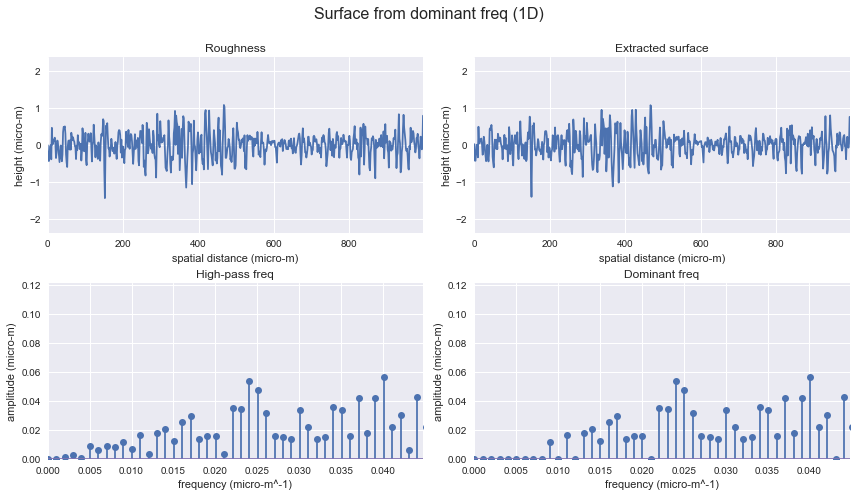

In [73]:
plot_size = (12, 7)
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=plot_size)
f.suptitle("Surface from dominant freq (1D)", fontsize=16)

ax1.plot(data_list, z_inv_high_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness')

ax2.plot(data_list, z_inv_dom_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Extracted surface')

ax3.stem(freq_half, z_fou_high_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax3.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('High-pass freq')

ax4.stem(freq_half, z_fou_dom_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax4.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Dominant freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [74]:
# count amount of dominant freq 1D
f_dom_no_1D = (df_freq_dom_1D['dominant?'] == True).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no_1D)

Amount of dominant freq:  467


In [75]:
# compare result

rSq_rou2dom_1D = r2_score(z_inv_high_1D.real, z_inv_dom_1D.real)

print('Roughness to Dominant surface 1D')
print('R-square: ', rSq_rou2dom_1D)

Roughness to Dominant surface 1D
R-square:  0.9806456137033939


## 2D dominant freq

### Autimatically assign cut-off amplitude

In [76]:
# # prepare dataframe for loop operation

# df_freq = pd.DataFrame(data = z_fou_high_2D_ishift,
#                        index = freq_full,
#                        columns = freq_full)

# df_freq_amp = abs(df_freq)

In [77]:
# # prepare list of freq -> to find cut-off amplitude of dominant freq

# list_freq_amp = df_freq_amp.values.flatten()
# list_freq_amp = sorted(list_freq_amp)

In [78]:
# # create table to compare result based on amount of dominant freq

# no_dom_freq_per = np.array([0.0025,0.005,0.01,
#                             0.02,0.04,0.06,0.08,0.1,
#                             0.2,0.4,0.6,0.8,1.0,
#                             1.5,2.0])

# df_dom_samp = pd.DataFrame(data = no_dom_freq_per, columns = ['no_f_per'])
# df_dom_samp['no_f'] = df_dom_samp['no_f_per'] * len(list_freq_amp) / 100
# df_dom_samp['no_f_int'] = df_dom_samp['no_f'].astype(int) + 1
# df_dom_samp['f_dom_amp_c'] = np.zeros(len(no_dom_freq_per))
# df_dom_samp['result_error'] = np.zeros(len(no_dom_freq_per))

In [79]:
# # find cut-off amplitude for dominant freq

# for i in range(len(no_dom_freq_per)):
#     df_dom_samp.loc[i,'f_dom_amp_c'] = list_freq_amp[-df_dom_samp.loc[i,'no_f_int']]
    
# df_dom_samp.head()

In [80]:
# # roughness plot

# plot_size = (10, 4)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
# f.suptitle("Roughness before extraction", fontsize=16)

# ax1.plot(data_list, z_inv_select_high)
# ax1.set_xlim(0, plt_dist_xlim_1D)
# ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
# ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
# ax1.title.set_text('Roughness of selected row')

# ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax2.title.set_text('Roughness image')
# ax2.grid(False)


# plt.tight_layout()
# f.subplots_adjust(top=0.88)

In [81]:
# def find_error_dom_f(no_f_per, freq_dom_amp_c):

#     df_freq_dom = df_freq.copy()
    
#     for x in df_freq.columns:
#         df_freq_dom[x] = np.where(
#             df_freq_amp[x] > freq_dom_amp_c,
#             df_freq_dom[x],
#             0.0
#         )
    
#     z_fou_dom = df_freq_dom.values
#     z_inv_dom_2D = ifft2(z_fou_dom)

# #----------------------------------------------------------------------------------------------------------------------------#
    
#     # find error
    
#     rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)
    
# #----------------------------------------------------------------------------------------------------------------------------#

#     # extract row for 1D plot

#     if x_or_y == 'x': 
#         z_inv_select_dom = z_inv_dom_2D[:, row_no]
        
#     if x_or_y == 'y':
#         z_inv_select_dom = z_inv_dom_2D[row_no, :]
    
# #----------------------------------------------------------------------------------------------------------------------------#

#     # plot graph to compare
    
    
#     title = 'No. of selected dom freq: ' + str(no_f_per) + ', R-Square error: ' + str("{0:.2f}".format(rSq_rou2dom_2D))
        
#     plot_size = (10, 4)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
#     f.suptitle(title, fontsize=16)
#     axis_dist = (0, data_len, 0, data_len)                                             # assign axis for spatial domain
#     axis_freq = (0, samp_rate, 0, samp_rate)                                           # assign axis for freq domain

#     ax1.plot(data_list, z_inv_select_dom)
#     ax1.set_xlim(0, plt_dist_xlim_1D)
#     ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
#     ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
#     ax1.title.set_text('Roughness of selected row')

#     ax2.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
#     ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
#     ax2.title.set_text('Roughness image')
#     ax2.grid(False)

#     plt.tight_layout()
#     f.subplots_adjust(top=0.88)
    
    
#     return rSq_rou2dom_2D

In [82]:
# # find result error between roughness and extracted surface

# for i in tqdm(range(len(no_dom_freq_per))):
#     df_dom_samp.loc[i,'result_error'] = find_error_dom_f(df_dom_samp.loc[i,'no_f_per'], df_dom_samp.loc[i,'f_dom_amp_c'])
    
# df_dom_samp

In [83]:
# # automatically assign cut-off dominant amplitude by acceptable percentage of error

# for i in range(len(no_dom_freq_per)):
#     if df_dom_samp.loc[i,'result_error'] > accept_dom_rSqua_2D:
#         freq_dom_amp_c_2D = df_dom_samp.loc[i,'f_dom_amp_c']
#         break
            
# freq_dom_amp_c_2D

### Extraction operation

In [84]:
# # remain only dominant freq in matrix

# df_freq_dom = df_freq.copy()
    
# for x in df_freq.columns:
#     df_freq_dom[x] = np.where(
#         df_freq_amp[x] > freq_dom_amp_c_2D,
#         df_freq_dom[x],
#         0.0
#     )

In [85]:
# z_fou_dom = df_freq_dom.values
# z_inv_dom_2D = ifft2(z_fou_dom)

# z_fou_dom_shift = fftshift(z_fou_dom)
# z_fou_dom_ishift = ifftshift(z_fou_dom_shift)

In [86]:
# # plot surface image

# plot_size = (15, 5)
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
# f.suptitle("Surface from dominant freq (2D)", fontsize=16)

# ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax1.title.set_text('Original')
# ax1.grid(False)

# ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax2.title.set_text('Roughness')
# ax2.grid(False)

# ax3.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist) 
# ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax3.title.set_text('Extracted surface')
# ax3.grid(False)

In [87]:
# # plot surface 3D

# plot_size = (16, 7)
# fig = plt.figure(figsize=plot_size)
# fig.suptitle('Surface from dominant freq (2D)', fontsize=16)


# # First subplot
# ax = fig.add_subplot(2, 3, 1, projection='3d') 

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_smooth_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Original surface')


# # Second subplot
# ax = fig.add_subplot(2, 3, 2, projection='3d')

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_high_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Roughness')


# # third subplot
# ax = fig.add_subplot(2, 3, 3, projection='3d')

# X = data_list
# Y = data_list
# X, Y = np.meshgrid(X, Y)
# Z = z_inv_dom_2D.real

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
# ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
# ax.title.set_text('Extracted surface')


# # fourth subplot
# ax = fig.add_subplot(2, 3, 4, projection='3d')          

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('All freq')


# # fifth subplot
# ax = fig.add_subplot(2, 3, 5, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_high_2D)

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('High-pass freq')


# # sixth subplot
# ax = fig.add_subplot(2, 3, 6, projection='3d')

# X = freq_full_shift
# Y = freq_full_shift
# X, Y = np.meshgrid(X, Y)
# Z = 1/data_pnts**2 * abs(z_fou_dom_shift)

# surf = ax.plot_surface(X, Y, Z)
# ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
# ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
# ax.title.set_text('Dominant freq')


# plt.tight_layout()
# fig.subplots_adjust(top=0.88)
# plt.show()

In [88]:
# # count amount of dominant freq
# f_dom_no = (df_freq_dom != 0).astype(int).values.sum()

# print('Amount of dominant freq: ', f_dom_no)

In [89]:
# # compare result 

# rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)

# print('Roughness to Dominant surface 2D')
# print('R-square: ', rSq_rou2dom_2D)

# Import data to csv file

## 1D import file

### Variables of full-frequency

In [90]:
df_excel_1D = df_freq_dom_1D[['freq', 'high_conv', 'amplitude', 'dominant?']].copy()

# keep only rows with dominant freq
df_excel_1D = df_excel_1D[(df_excel_1D[['dominant?']] == True).any(axis=1)]
df_excel_1D = df_excel_1D.reset_index(drop=True)

In [91]:
df_excel_1D = df_excel_1D.drop(['dominant?'], axis=1)
df_excel_1D = df_excel_1D.rename(index=str, columns={'freq':'f(um)^-1', 
                                                     'high_conv':'FourierCoef', 
                                                     'amplitude':'A(um)'
                                                    })

df_excel_1D['FourierCoef'] = df_excel_1D['FourierCoef'] / data_pnts
df_excel_1D['Phs(rad)'] = np.angle(df_excel_1D['FourierCoef'])

### Variables of half-frequency

In [92]:
# keep only positive freq

df_excel_1D_pos = df_excel_1D.copy()
df_excel_1D_pos = df_excel_1D_pos[(df_excel_1D_pos[['f(um)^-1']] >= 0).any(axis=1)]
df_excel_1D_pos = df_excel_1D_pos.reset_index(drop=True)

In [93]:
# correct the amplitude by *2

f_dom_no_1D_pos = int(f_dom_no_1D/2)

df_excel_1D_pos['FourierCoef'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['FourierCoef'],
    2 * df_excel_1D_pos['FourierCoef']
)

df_excel_1D_pos['A(um)'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['A(um)'],
    2 * df_excel_1D_pos['A(um)']
)

df_excel_1D_pos.head()

,f(um)^-1,FourierCoef,A(um),Phs(rad)
0,0.009028,(0.01123507047932591+0.003460245600272588j),0.011756,0.298767
1,0.011034,(0.006303105640646074+0.015557855477267781j),0.016786,1.185867
2,0.013041,(-0.0007073367657956824+0.017787355828032363j),0.017801,1.610542
3,0.014044,(0.012468759439752078+0.0167488933922815j),0.020881,0.930855
4,0.015047,(-0.00490526810422883-0.011603296649620932j),0.012598,-1.970758


In [94]:
print('Amount of dominant freq (full): ', f_dom_no_1D)
print('Amount of dominant freq (half): ', f_dom_no_1D_pos)

Amount of dominant freq (full):  467
Amount of dominant freq (half):  233


In [95]:
# # import dataframe to csv

# df_excel_1D_pos.to_csv('onefile_variables_1D.csv', index=False)

### Height of dominant surface

In [96]:
df_excel_1D_z_dom = pd.DataFrame(data = data_list, columns = ['x(um)'])
df_excel_1D_z_dom['z(um)'] = z_inv_dom_1D.real

df_excel_1D_z_dom.head()

,x(um),z(um)
0,0.0000,0.022690
1,1.5625,-0.425255
2,3.1250,-0.427762
3,4.6875,-0.195463
4,6.2500,0.006982


In [97]:
# # import dataframe to csv

# df_excel_1D_z_dom.to_csv('onefile_height_1D.csv', index=False)

## 2D import file

### Variables of full-frequency

In [98]:
# df_freq_dom = pd.DataFrame(data = z_fou_dom_ishift)

# # assign index to dataframe
# df_freq_dom.index = freq_full
# df_freq_dom.columns = freq_full

In [99]:
# # unpivot table of df_freq_dom

# df_excel_2D = df_freq_dom.unstack().reset_index(name='FourierCoef')
# df_excel_2D.rename(columns={'level_0': 'fx(um)^-1', 'level_1': 'fy(um)^-1'}, inplace=True)

In [100]:
# # assign amplitude and phase

# df_excel_2D['FourierCoef'] = df_excel_2D['FourierCoef'] / data_pnts**2
# df_excel_2D['A(um)'] = np.abs(df_excel_2D['FourierCoef'])
# df_excel_2D['Phs(rad)'] = np.angle(df_excel_2D['FourierCoef'])


# # remain only dominant freq

# df_excel_2D = df_excel_2D[(df_excel_2D[['FourierCoef']] != 0).any(axis=1)]
# df_excel_2D = df_excel_2D.reset_index(drop=True)

### Variables of half-frequency

In [101]:
# # remain only freq in half positive quarters

# df_excel_2D_half = df_excel_2D.copy()
# df_excel_2D_half = df_excel_2D_half[(df_excel_2D_half[['fx(um)^-1']] >= 0).any(axis=1)]
# df_excel_2D_half = df_excel_2D_half.reset_index(drop=True)

In [102]:
# # correct the amplitude by *2

# f_dom_no_half = len(df_excel_2D_half)

# df_excel_2D_half['FourierCoef'] = np.where(
#     df_excel_2D_half['fx(um)^-1'] == 0,
#     df_excel_2D_half['FourierCoef'],
#     2 * df_excel_2D_half['FourierCoef']
# )

# df_excel_2D_half['A(um)'] = np.where(
#     df_excel_2D_half['fx(um)^-1'] == 0,
#     df_excel_2D_half['A(um)'],
#     2 * df_excel_2D_half['A(um)']
# )

# df_excel_2D_half.head()

In [103]:
# print('Amount of dominant freq (full): ', f_dom_no)
# print('Amount of dominant freq (half): ', f_dom_no_half)

In [104]:
# # import dataframe to csv

# df_excel_2D_half.to_csv('onefile_variables_2D.csv', index=False)

In [105]:
# # scatter plot to compare full & half dominant freq

# axis_freq = (0, samp_rate, 0, samp_rate)

# plot_size = (8, 4)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
# f.suptitle("Scatter plot of dominant frequency (2D)", fontsize=16)


# ## plot1
# data = df_excel_2D[['fx(um)^-1', 'fy(um)^-1']].values
# x1, y1 = data.T

# ax1.scatter(x1,y1)
# ax1.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
# ax1.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
# ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
# ax1.title.set_text('Full dominant frequency')


# ## plot2
# data = df_excel_2D_half[['fx(um)^-1', 'fy(um)^-1']].values
# x2, y2 = data.T

# ax2.scatter(x2,y2)
# ax2.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
# ax2.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
# ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
# ax2.title.set_text('Half dominant frequency')


# plt.tight_layout()
# f.subplots_adjust(top=0.88)

### Height of dominant surface

In [106]:
# df_excel_2D_z_dom = pd.DataFrame(data = z_inv_dom_2D.real, columns = data_list)
# df_excel_2D_z_dom.index = data_list

# df_excel_2D_z_dom.iloc[0:5,0:5]

In [107]:
# # cut length of imported height as assign

# if assign_csv_len == 'y':
#     df_excel_2D_z_dom = df_excel_2D_z_dom.iloc[0:csv_len_2D, 0:csv_len_2D]

# print('Processed length: ', data_pnts)
# print('Imported length:  ', len(df_excel_2D_z_dom))

In [108]:
# # unpivot table

# temp = df_excel_2D_z_dom.stack()
# df_excel_2D_z_dom_melt = pd.DataFrame(temp)
# df_excel_2D_z_dom_melt.columns = ['z(um)']
# df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.reset_index()
# df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.rename(index=str, columns={'level_0': 'x(um)',
#                                                                            'level_1': 'y(um)'})

# df_excel_2D_z_dom_melt.head()

In [109]:
# # import dataframe to csv

# df_excel_2D_z_dom_melt.to_csv('onefile_height_2D.csv', index=False)

# Surface reconstruction

## 1D surface reconstruction

In [110]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_1D_pos = np.zeros(data_pnts_recon)
x = np.array(data_list_recon)

for i in tqdm(range(f_dom_no_1D_pos)):
    
    A = df_excel_1D_pos['A(um)'].iloc[i]
    f = df_excel_1D_pos['f(um)^-1'].iloc[i]
    ph = df_excel_1D_pos['Phs(rad)'].iloc[i]
        
    zi = A * np.cos(2*np.pi*f*x + ph)
    z_recon_1D_pos = z_recon_1D_pos + zi
    
z_recon_1D_pos[0:5]

100%|██████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 7925.59it/s]


array([ 0.01459156, -0.46355222, -0.27428303, -0.05428818, -0.0564462 ])

In [111]:
df_1D_z_recon = pd.DataFrame(data = data_list_recon, columns = ['x'])
df_1D_z_recon['z'] = z_recon_1D_pos.real

df_1D_z_recon.head()

,x,z
0,0.0,0.014592
1,2.0,-0.463552
2,4.0,-0.274283
3,6.0,-0.054288
4,8.0,-0.056446


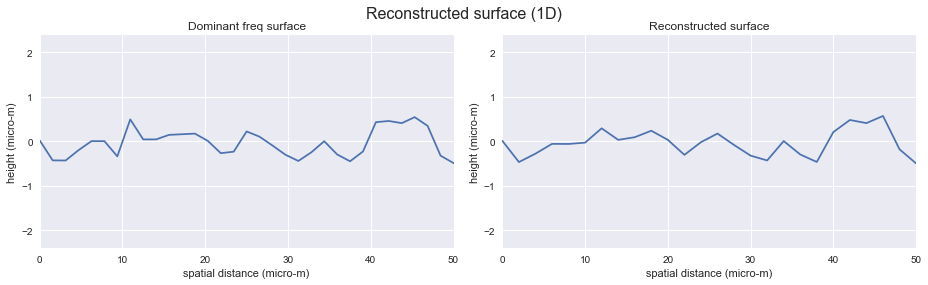

In [112]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (1D)", fontsize=16)

ax1.plot(data_list, z_inv_dom_1D.real)
ax1.set_xlim(0, data_list_recon[-1])
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Dominant freq surface')

ax2.plot(data_list_recon, z_recon_1D_pos)
ax2.set_xlim(0, data_list_recon[-1])
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Reconstructed surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [113]:
# prepare file name

elemForName = '_' + str(elemsize_recon) + 'um'

pntForName = '_' + str(data_pnts_recon) + 'pnts'

trimForName = '_trim' + str(trim_min) + '-' + str(trim_max)

outputFileName = 'recon1D_' + input_file[:-4] + elemForName + pntForName + trimForName + '_roughness'

print(outputFileName)

recon1D_R04.bottom_50um_26pnts_trim200-1200_roughness


In [114]:
# import dataframe to csv

df_1D_z_recon.to_csv(outputFileName + '.csv', index=False)

In [115]:
# # compare result

# rSq_dom2recon_1D = r2_score(z_inv_dom_1D.real, z_recon_1D_pos)
# rSq_rou2recon_1D = r2_score(z_inv_high_1D.real, z_recon_1D_pos)

# print('Dominant to reconstructed surface 1D')
# print('R-square: ', rSq_dom2recon_1D)
# print('\nRoughness to reconstructed surface 1D')
# print('R-square: ', rSq_rou2recon_1D)

## 2D surface reconstruction

In [116]:
# # reconstruct surface by superposition of sinusoidal wave

# z_recon_2D_half = pd.DataFrame(np.zeros((data_pnts, data_pnts)))
# x, y = np.meshgrid(data_list, data_list)

# for i in tqdm(range(f_dom_no_half)):
    
#     A = df_excel_2D_half['A(um)'].iloc[i]
#     fx = df_excel_2D_half['fx(um)^-1'].iloc[i]
#     fy = df_excel_2D_half['fy(um)^-1'].iloc[i]
#     ph = df_excel_2D_half['Phs(rad)'].iloc[i]
    
#     zi = A * np.cos(2*np.pi*(fx*x + fy*y) + ph)
#     z_recon_2D_half = z_recon_2D_half + zi
    
# z_recon_2D_half.iloc[0:5,0:5]

In [117]:
# plot_size = (8, 4)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
# f.suptitle("Reconstructed surface (2D)", fontsize=16)

# ax1.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
# ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax1.title.set_text('Dominant freq surface')
# ax1.grid(False)

# ax2.imshow(z_recon_2D_half.values.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist) 
# ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
# ax2.title.set_text('Reconstructed surface')
# ax2.grid(False)

# plt.tight_layout()
# f.subplots_adjust(top=0.88)

In [118]:
# # compare result

# rSq_dom2recon_2D = r2_score(z_inv_dom_2D.real, z_recon_2D_half.values.real)
# rSq_rou2recon_2D = r2_score(z_inv_high_2D.real, z_recon_2D_half.values.real)

# print('Dominant to reconstructed surface 2D')
# print('R-square: ', rSq_dom2recon_2D)
# print('\nRoughness to reconstructed surface 2D')
# print('R-square: ', rSq_rou2recon_2D)